In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from dataset import SIGNUMDataset
import dataset
import skeleton_utils as skel
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import model as model
import torch.nn as nn
import numpy as np

from transformers import BertTokenizer, BertModel

In [2]:
test_dataset = SIGNUMDataset('/scratch/datasets/SIGNUM', use_pose=True, subsample=10)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn=test_dataset.collate)

In [3]:
language_encoder = model.language_encoder()
pose_encoder = model.Encoder()
pose_decoder = model.Decoder(hidden_size=768, pose_size=57*2, trajectory_size=0,
               use_h=False, start_zero=False, use_tp=False,
               use_lang=False, use_attn=False)

/scratch/frankyu/anaconda3/envs/532/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [4]:
CosineSimilarity = nn.CosineSimilarity()
loss_fn = torch.nn.MSELoss()
num_joints = 57
joint_dim = 2
num_epochs = 50
optimizerDecoder = torch.optim.SGD(pose_decoder.parameters(), lr=0.1)

In [5]:
for epoch in range(num_epochs):
    for i, data in enumerate(test_dataloader):
        if i == 1:
            break
        optimizerDecoder.zero_grad()
        
        img_seq = torch.FloatTensor(data['img_seq'])
        pose_seq = data['pose_seq']
        label_seq = data['label_seq']
        transl_eng = data['transl_eng']
        transl_deu = data['transl_deu']
        img_seq_len = data['seq_len']
        
        total_sequence = sum(np.array(img_seq_len))
        
        lang_embed = torch.FloatTensor(language_encoder(transl_eng))
#         print(img_seq_len)
#         print(pose_seq.shape)
#         print(label_seq.shape)

        output = pose_decoder(lang_embed, max(img_seq_len), pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1),\
                              epoch=epoch)
#         print(output.shape)
#         print(np.array(img_seq_len)-1)
        pred_pose = dataset.unpad_sequence(output, img_seq_len).data
#         print(pred_pose.shape)

        gt_label = dataset.unpad_sequence(label_seq, np.array(img_seq_len)).data.view(-1, num_joints*joint_dim)
#         print(gt_label.shape)
#         print(gt_label[0])

#         mean = test_dataset.mean.unsqueeze(0).repeat(total_sequence, 1, 1)
#         std = test_dataset.std.unsqueeze(0).repeat(total_sequence, 1, 1)
#         denorm_output = skel.denormalize_pose(pred_pose.view(-1, 57, 2), mean, std)
#         denorm_label = skel.denormalize_pose(gt_label.view(-1, 57, 2), mean, std)

        loss = loss_fn(pred_pose, gt_label)
#         loss = loss_fn(denorm_output, denorm_label)
        loss.backward()
        optimizerDecoder.step()
        print(loss)

tensor(2.3672, grad_fn=<MseLossBackward>)
tensor(2.2977, grad_fn=<MseLossBackward>)
tensor(1.6885, grad_fn=<MseLossBackward>)
tensor(1.6741, grad_fn=<MseLossBackward>)
tensor(1.2817, grad_fn=<MseLossBackward>)
tensor(1.1529, grad_fn=<MseLossBackward>)
tensor(1.0914, grad_fn=<MseLossBackward>)
tensor(0.9621, grad_fn=<MseLossBackward>)
tensor(0.9341, grad_fn=<MseLossBackward>)
tensor(0.9243, grad_fn=<MseLossBackward>)
tensor(0.9158, grad_fn=<MseLossBackward>)
tensor(0.8920, grad_fn=<MseLossBackward>)
tensor(0.8752, grad_fn=<MseLossBackward>)
tensor(0.8682, grad_fn=<MseLossBackward>)
tensor(0.8638, grad_fn=<MseLossBackward>)
tensor(0.8599, grad_fn=<MseLossBackward>)
tensor(0.8565, grad_fn=<MseLossBackward>)
tensor(0.8532, grad_fn=<MseLossBackward>)
tensor(0.8502, grad_fn=<MseLossBackward>)
tensor(0.8467, grad_fn=<MseLossBackward>)
tensor(0.8433, grad_fn=<MseLossBackward>)
tensor(0.8392, grad_fn=<MseLossBackward>)
tensor(0.8353, grad_fn=<MseLossBackward>)
tensor(0.8312, grad_fn=<MseLossBac

In [6]:
vis_pose = pred_pose.view(pred_pose.shape[0], -1 , 2).detach()
print(vis_pose.shape)

torch.Size([39, 57, 2])


In [7]:
vis_gt = gt_label.view(pred_pose.shape[0], -1 , 2).detach()
print(vis_gt.shape)

torch.Size([39, 57, 2])


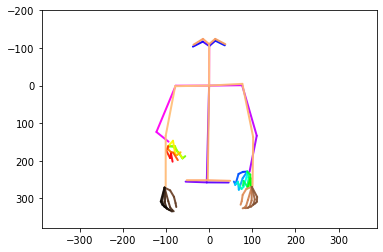

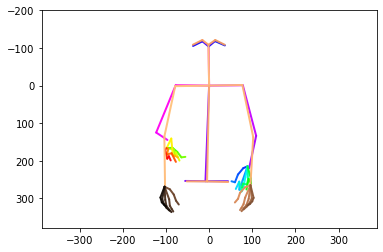

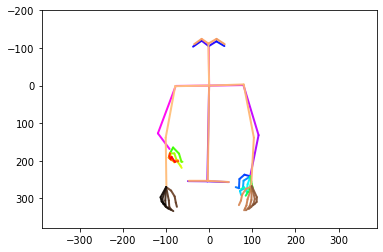

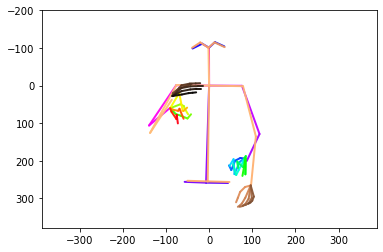

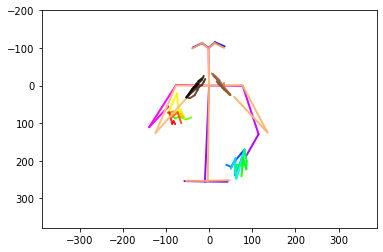

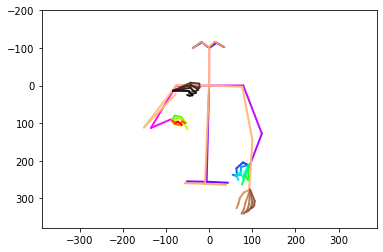

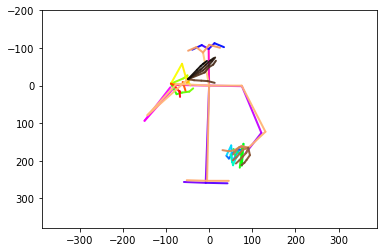

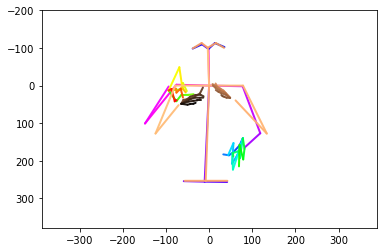

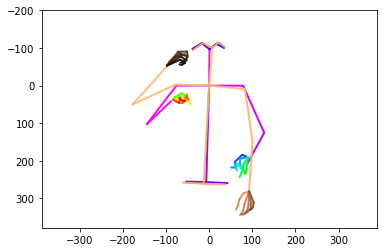

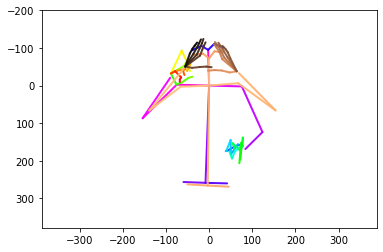

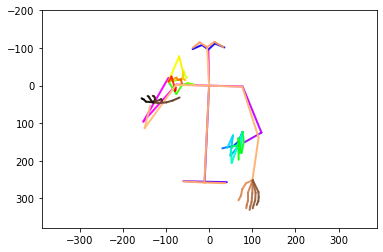

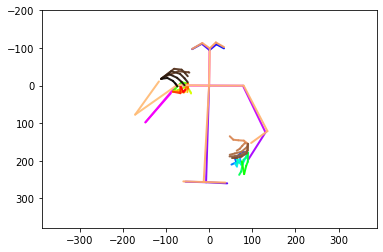

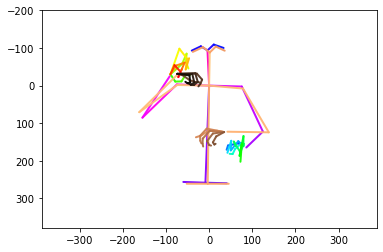

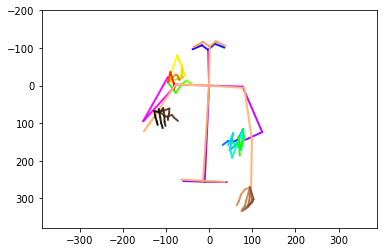

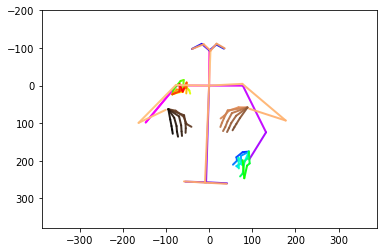

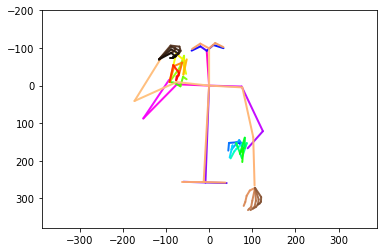

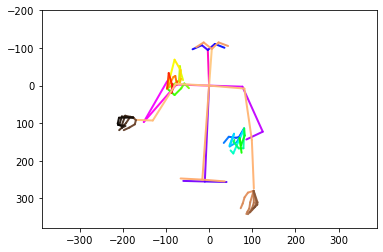

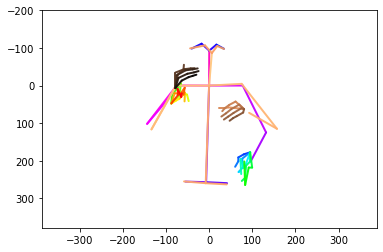

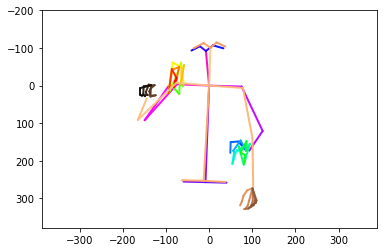

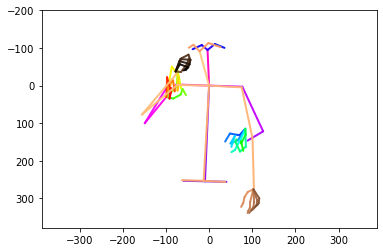

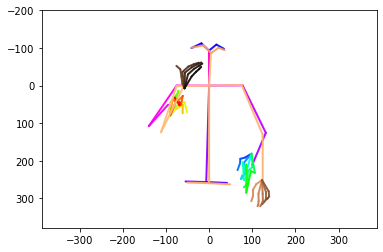

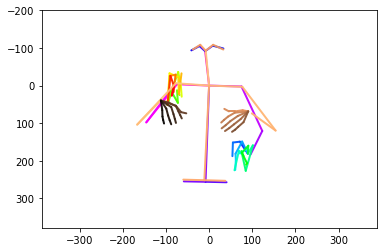

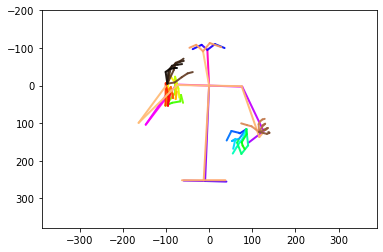

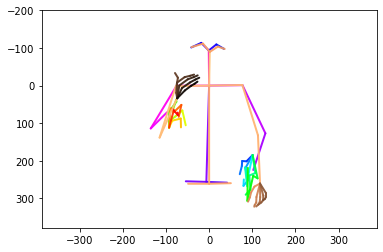

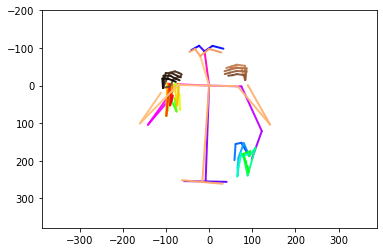

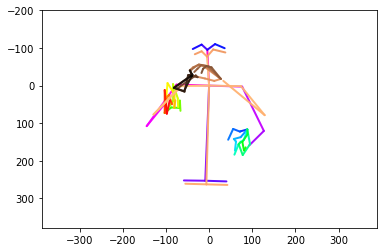

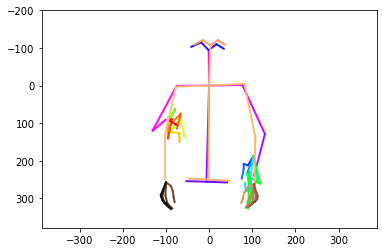

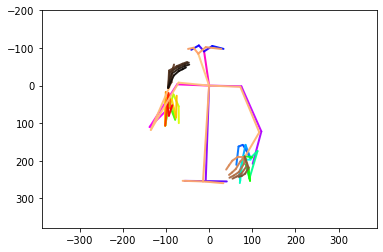

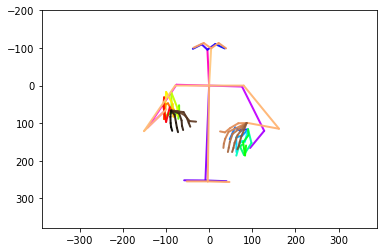

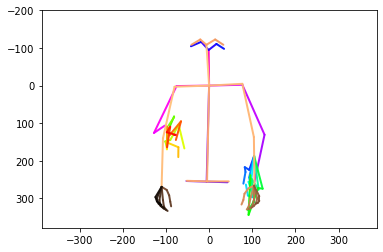

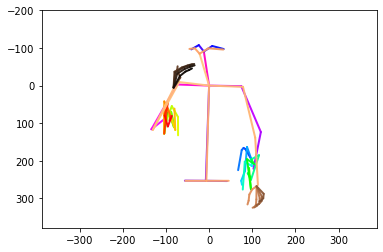

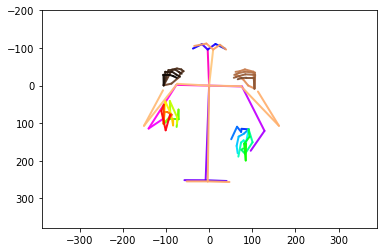

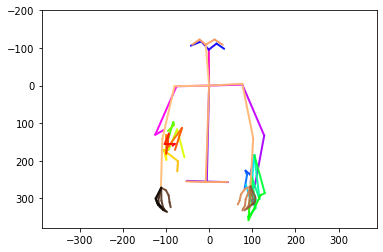

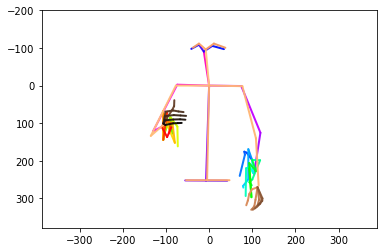

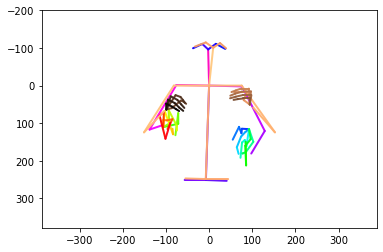

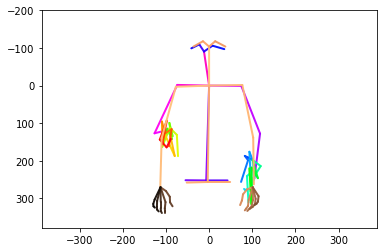

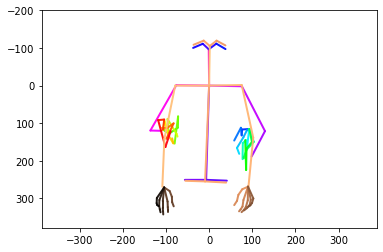

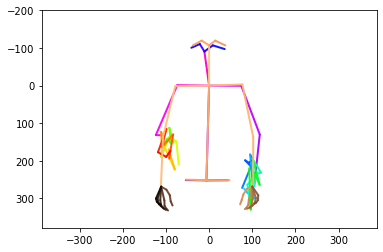

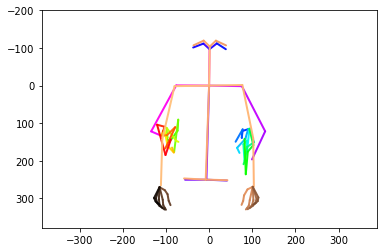

In [8]:
fig = plt.figure()

for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()

In [9]:
print(pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1)[:,0,...].shape)
print((pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1).shape))
print(lang_embed.shape)

torch.Size([3, 114])
torch.Size([3, 14, 114])
torch.Size([3, 768])


In [10]:
lang_embed = torch.FloatTensor(language_encoder(transl_eng))
test_output = pose_decoder.sample(lang_embed, max(img_seq_len),\
                             pose_seq.view(pose_seq.shape[0], pose_seq.shape[1], -1)[:,0,...],\
                             attn=None)
print(test_output.shape)

torch.Size([3, 14, 114])


torch.Size([39, 57, 2])


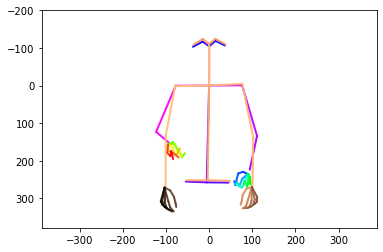

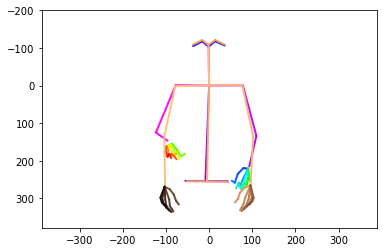

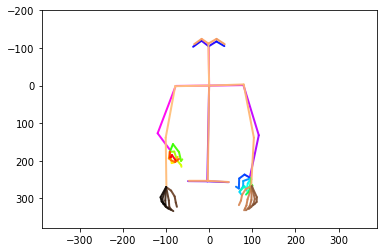

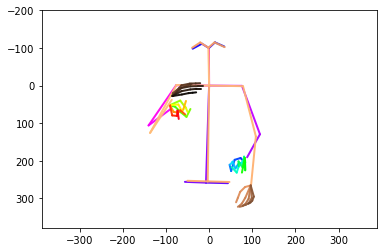

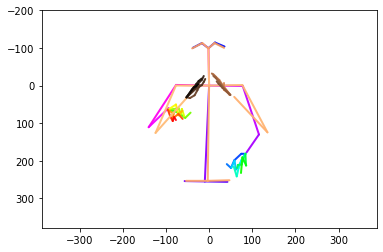

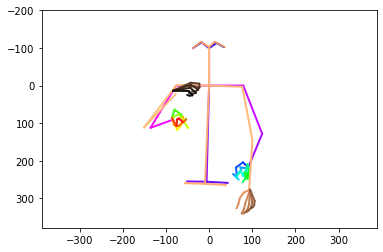

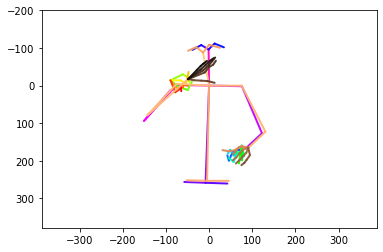

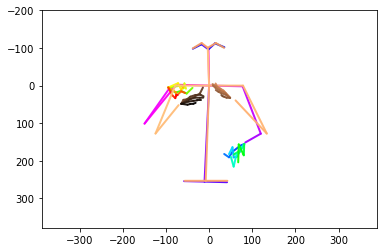

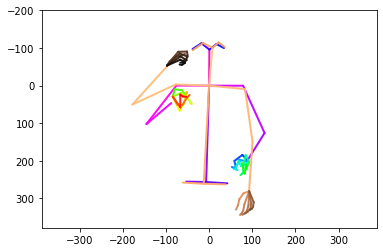

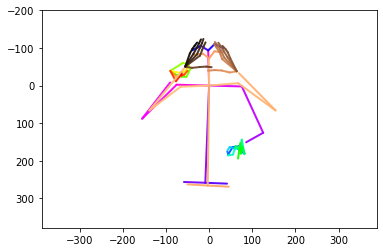

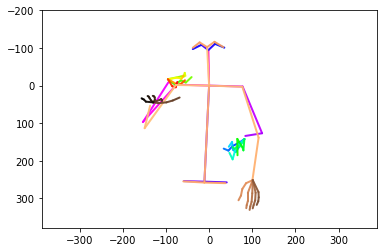

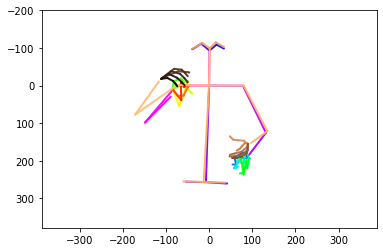

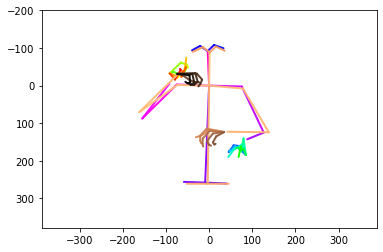

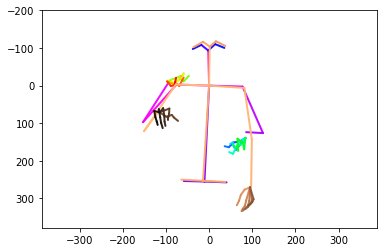

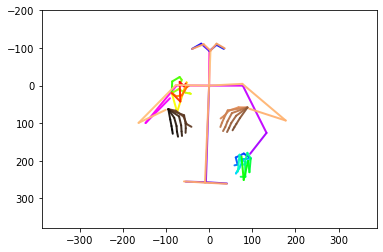

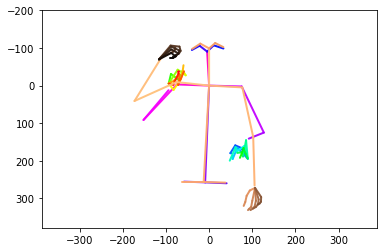

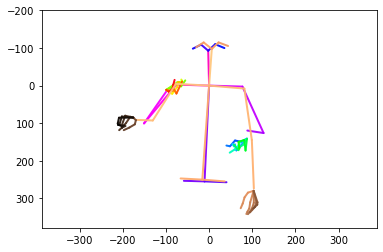

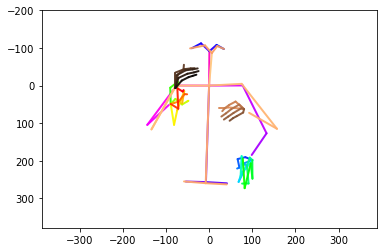

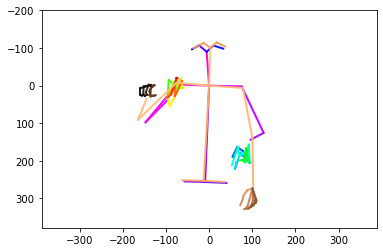

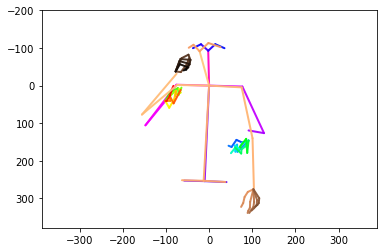

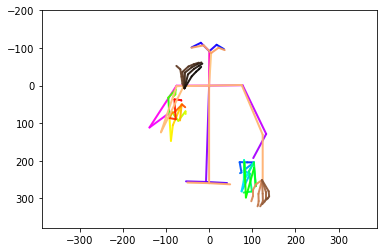

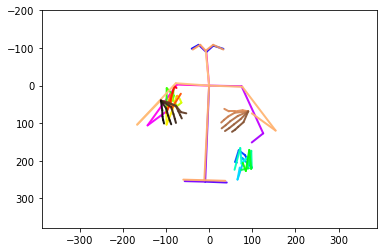

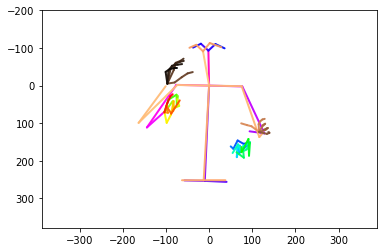

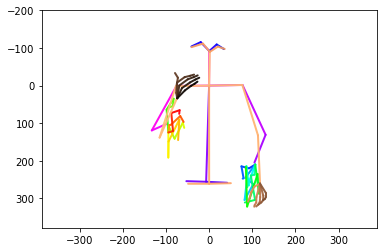

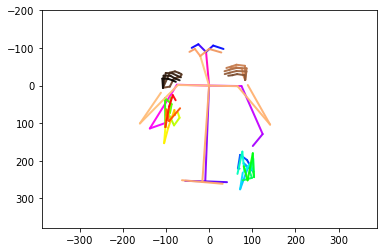

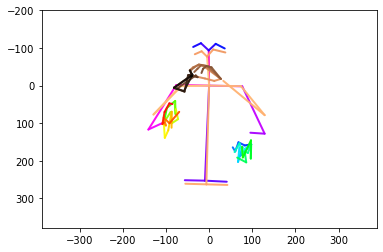

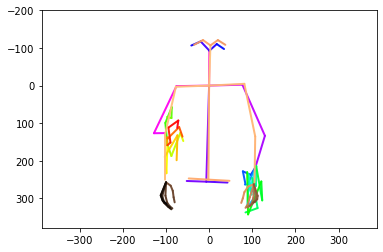

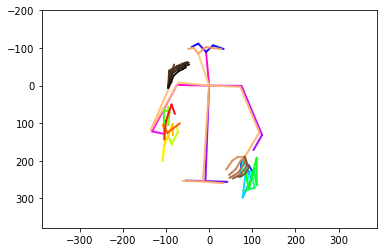

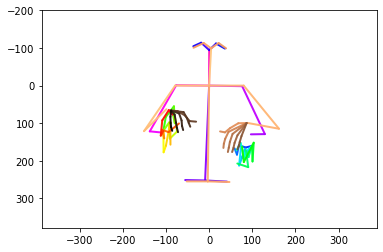

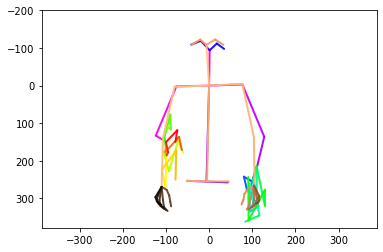

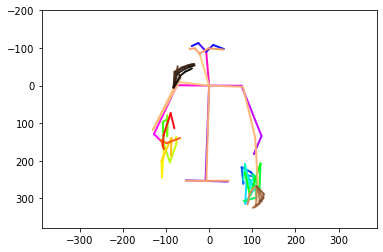

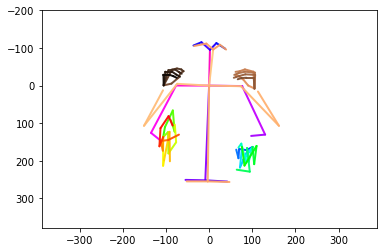

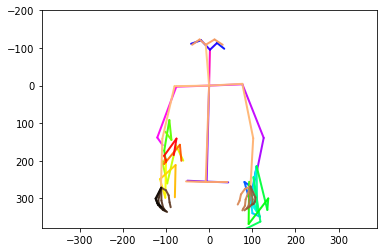

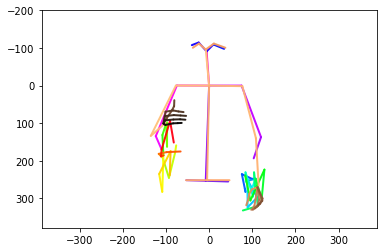

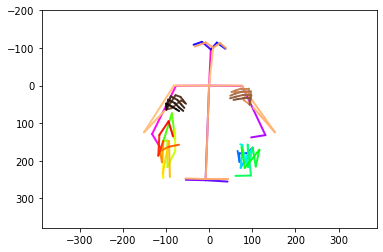

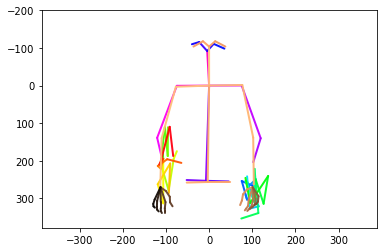

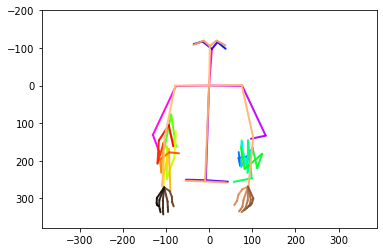

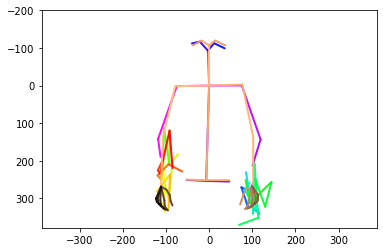

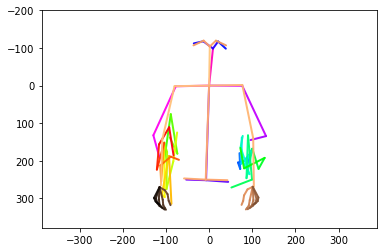

In [11]:
test_output = dataset.unpad_sequence(test_output, img_seq_len).data
vis_pose = test_output.view(test_output.shape[0], -1 , 2).detach()
print(vis_pose.shape)
for i, pose in enumerate(vis_pose):
#     clear_output(wait=True)
    ax = plt.subplot(111)
    pose = skel.denormalize_pose(pose, test_dataset.mean, test_dataset.std)
    pose_gt = skel.denormalize_pose(vis_gt[i], test_dataset.mean, test_dataset.std)
#     print(pose.shape)
    skel.plot_pose2D(ax, pose)
    skel.plot_pose2D(ax, pose_gt, colormap='copper')
    plt.show()